In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression as LR
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('..'))
from backtest_helpers import cross_section_regression, compute_betas, set_date_index, separate

In [2]:
# additional helpers
def compute_mdd(return_series):
    '''
    args:
        returns_series: time series of returns for a strategy or asset
    does:
        computes the maximum drawdown (mdd) and start/end dates. mdd is defined
        as the maximum peak-to-trough decline in a price series. Trough is the lowest
        point before a new high-level is achieved
    returns:
        max drawdown, start date, and end date of mdd
    '''
    price_series = (1 + return_series).cumprod()
    price_series = price_series.dropna()

    # Append the value 1 to the start of the series
    prev_index = price_series.index[0] - pd.DateOffset(months=1)
    price_series = pd.concat([pd.Series([1], index=[prev_index]), price_series], axis=0)

    # Find peaks
    running_max = price_series.cummax()

    drawdown = (price_series - running_max) / running_max
    mdd = drawdown.min()
    mdd_end = drawdown.idxmin()
    mdd_start = price_series.loc[:mdd_end].idxmax()

    return mdd, mdd_start, mdd_end


def compute_sharpe_stderr(return_df, risk_free=None, 
                          ergodic=False, annualized=True):
    '''
    args:
        return_df: time series of returns for at least one strategy or asset (T x N)
        risk_free: time series of risk free returns (0 for self-financing)
        ergodic: dummy for whether to use ergodic or naive stderr formula
    does:
        computes the standard error of the Sharpe ratio, using one of two normal formulas
    returns:
        standard error of the Sharpe ratio
    '''
    scale = np.sqrt(12) if annualized else 1
    
    # T x N
    excess_return = return_df.sub(risk_free, axis=1) if risk_free is not None else return_df
    mean_return = excess_return.mean()
    std_return = excess_return.std()

    # Compute the number of dates that were used to compute sample stats
    T = excess_return.count(axis=0)

    # Compute Sharpe Ratio (unscaled)
    SR = mean_return / std_return
    
    if ergodic:
        # Compute higher moments for ergodic assumption (skewness and raw kurtosis)
        skewness = excess_return.apply(lambda x: stats.skew(x.dropna(), bias=False))
        kurtosis = excess_return.apply(lambda x: stats.kurtosis(x.dropna(), fisher=False, bias=False))

        SE = (1 / (T - 1) * (1 + 0.25 * (SR ** 2) * (kurtosis - 1) - SR * skewness)) ** 0.5
    else:
        SE = (1 / (T - 1) * (1 + 0.5 * SR ** 2)) ** 0.5
    
    return SE * scale


# sharpe
def compute_sharpe(returns_series, risk_free_series):
    """
    Compute annualized Sharpe ratio.
    
    Parameters:
    returns_series: Series of strategy returns
    risk_free_series: Series of risk-free rates (monthly)
    """
    # Remove NaN
    returns_clean = returns_series.dropna()
    
    if len(returns_clean) < 2:
        return 0.0
    
    # Align risk-free rate with returns
    rf_aligned = risk_free_series.reindex(returns_clean.index).fillna(0)
    excess_returns = returns_clean - rf_aligned

    # Annualize
    annual_excess_ret = excess_returns.mean() * 12
    annual_vol = returns_clean.std() * np.sqrt(12)
    
    # Check for zero/invalid volatility
    if annual_vol == 0 or np.isnan(annual_vol) or annual_vol < 1e-10:
        return 0.0
    
    sharpe = annual_excess_ret / annual_vol    
    return sharpe

def softmax(sharpes, temperature=1.0):
    sharpes = np.array(sharpes)
    
    # Check if all Sharpes are the same or all zero
    if np.allclose(sharpes, sharpes[0]) or np.all(sharpes == 0):
        print("Warning: All Sharpes equal, using equal weighting")
        return np.ones(len(sharpes)) / len(sharpes)
    
    # Shift to make all positive
    shifted = sharpes - sharpes.min() + 0.01
    
    # Apply softmax
    exp_vals = np.exp(shifted / temperature)
    weights = exp_vals / exp_vals.sum()
    
    return weights


### Data

In [3]:
# Preprocess data
df = pd.read_excel('value_weighted_industries.xls', skiprows=3)
df = set_date_index(df, date_column_name='Unnamed: 0', date_format_str='%Y%m')

def convert_monthly(price_df):
    monthly_prices = price_df.resample('ME').last()
    monthly_returns = monthly_prices.pct_change()
    monthly_returns = monthly_returns.iloc[1:]  # Drop first NaN row
    return monthly_returns

# Convert to monthly returns
monthly_returns = convert_monthly(df)
monthly_returns = monthly_returns / 100  # Convert from percentage to decimal
# reindex monthly returns to beginning of month
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp()

print("Number with returns at beginning: ", monthly_returns.iloc[0, :].notna().sum())

# Read in the risk free rate
ff_returns = pd.read_excel('ff_factor_returns.xls')
ff_returns = set_date_index(ff_returns, date_column_name='Unnamed: 0', date_format_str='%Y%m')
ff_returns /= 100
risk_free_series = ff_returns['RF']

display(monthly_returns.head())
display(risk_free_series.head())

Number with returns at beginning:  49


,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1963-08-01,-0.011053,-0.112826,0.011401,-0.019772,-0.038150,-0.019921,-0.122000,-0.764286,-0.424667,-0.119286,...,0.123095,-0.039170,1.045000,-0.072453,-0.012542,-0.058387,-0.026667,-0.017412,0.026866,0.032798
1963-09-01,0.050625,-0.013235,-0.011636,-0.004252,-0.015916,-0.020239,-0.012883,-0.004356,-0.012203,-0.018649,...,-0.013560,-0.015230,-0.013910,-0.008263,-0.033458,-0.017444,-0.014690,-0.022507,-0.017915,-0.008554
1963-10-01,-0.009330,-0.027582,-0.022222,-0.020407,-0.023664,-0.040408,-0.018673,-0.016678,-0.041022,-0.016801,...,-0.027136,-0.014611,-0.018545,-0.006435,-0.014422,-0.009194,-0.021324,-0.021981,-0.011279,0.015385
1963-11-01,0.225385,-0.011450,-0.015273,-0.004375,-0.019740,-0.010530,-0.030255,-0.006884,-0.010424,-0.015333,...,-0.010674,0.011348,-0.038582,-0.036098,-0.042523,0.120370,-0.037208,-0.019741,0.007800,-0.009432
1963-12-01,-0.020621,-0.072821,-0.110000,-0.026806,-0.020622,0.020000,-0.006322,0.034355,-0.246667,-0.006528,...,0.001739,0.001026,-0.008362,-0.013271,-0.014848,-0.015341,-0.013604,-0.012331,0.006067,0.378667


date
1963-07-01    0.0027
1963-08-01    0.0025
1963-09-01    0.0027
1963-10-01    0.0029
1963-11-01    0.0027
Name: RF, dtype: float64

## TSMOM

Remember that for a singular asset we have that the TSMOM return for lookforward = 1 is the sign (long/short) based on the previous 12 month returns, scaled by the ex-ante volatility (40/$\sigma_{t}$), multiplied by the return in the next period of that asset.

$$r^{\mathrm{TSMOM},s}_{t,t+1} = \operatorname{sign}\!\left(r^{s}_{t-12,t}\right) \frac{40\%}{\sigma^{s}_{t}} \, r^{s}_{t,t+1}$$

So for the whole portfolio: 
$$ r^{\mathrm{TSMOM}}_{t,t+1} = \frac{1}{S_t} \sum_{s=1}^{S_t} \operatorname{sign}\!\left(r^{s}_{t-12,t}\right) \frac{40\%}{\sigma^{s}_{t}} \, r^{s}_{t,t+1}. $$


### Ex-Ante Volatility Calculation

From Moskowitz paper: ex-ante annualized variance at time $t$ is calculated as:

$$\sigma_t^2 = T \sum_{i=0}^{\infty} (1-\delta)\delta^i (r_{t-1-i} - \bar{r}_t)^2$$

Where:
- $T = 12$ for monthly data (or 261 for daily data)
- $\delta = \frac{\text{COM}}{1 + \text{COM}}$ is the decay parameter
- COM = center of mass = 3 months for monthly data (60 days for daily)
- $(1-\delta)\delta^i$ are exponential weights that sum to 1
- $\bar{r}_t$ is the exponentially weighted mean return

The exponentially weighted mean is:

$$\bar{r}_t = (1-\delta) \cdot r_t + \delta \cdot \bar{r}_{t-1}$$

The volatility is then lagged by 1 period: $\hat{\sigma}_t = \sigma_{t-1}$

In [4]:
# Compute ex-ante volatility
def ex_ante_volatility(df, com=3, t=12):
    # standard parameters, COM = 3, T = 12 for monthly data
    delta = com / (1 + com)
    alpha = 1 - delta
    
    ewm_mean = df.ewm(alpha=alpha, adjust=False).mean()
    ewm_variance = ((df - ewm_mean) ** 2).ewm(alpha=alpha, adjust=False).mean()
    
    # Annualize and take square root
    annual_vol = np.sqrt(t * ewm_variance)
    
    # Lag by 1 period to avoid look-ahead bias
    return annual_vol.shift(1)

# calculate volatility-scaled returns

# sign +1 if past 12 month return > 0, -1 if less, 0 o.w.
def calc_signal(df, lookback=12):
    cum_return = df.rolling(window=lookback).apply(lambda x: (1 + x).prod() - 1, raw=True)
    return np.sign(cum_return)

def tsmom_returns(df, target_vol=0.40, lookback=12, com=3, min_vol=0.01, max_leverage=10):
    signals = calc_signal(df, lookback=lookback)
    volatilities = ex_ante_volatility(df, com=com)
    
    # Floor volatility to prevent inf position sizes
    volatilities = volatilities.clip(lower=min_vol)
    
    position_sizes = target_vol / volatilities
    position_sizes = position_sizes.clip(upper=max_leverage)

    tsmom_ret = signals * position_sizes * df
    
    return tsmom_ret

tsmom_returns_df = tsmom_returns(monthly_returns, target_vol=0.40, lookback=12, com=3) 

## Bayesian Weighting


In [5]:
# Complete Bayesian-weighted TSMOM function
def bayesian_weighted_tsmom(returns_df, risk_free_series, lookbacks, 
                            train_years=5, test_years=1, temperature=1.0, min_vol=0.05, max_leverage=10):
   
    """
    Bayesian-weighted TSMOM with rolling windows.
    
    Parameters:
    returns_df: DataFrame of monthly returns (industries as columns)
    risk_free_series: Series of monthly risk-free rates
    lookbacks: list of lookback periods to test (default: [1,2,3,4,5,6,7,8])
    train_years: training window size in years (default: 5)
    test_years: testing window size in years (default: 1)
    temperature: softmax temperature (default: 1.0)
    min_vol: minimum volatility floor (default: 0.01)
    
    Returns:
    final_returns: Series of weighted strategy returns
    weights_df: DataFrame showing weights over time
    """
    
    train_months = train_years * 12
    test_months = test_years * 12
    
    results = []
    weights_history = []
    
    start_idx = 0
    window_num = 0
    
    while start_idx + train_months + test_months <= len(returns_df):
        
        window_num += 1
        train_end = start_idx + train_months
        test_end = train_end + test_months
        
        train_data = returns_df.iloc[start_idx:train_end]
        test_data = returns_df.iloc[train_end:test_end]
        
        # Slice risk-free series to match train/test periods
        train_rf = risk_free_series.iloc[start_idx:train_end]
        test_rf = risk_free_series.iloc[train_end:test_end]
        
        print(f"\n{'='*60}")
        print(f"Window {window_num}")
        print(f"Training: {train_data.index[0].strftime('%Y-%m')} to {train_data.index[-1].strftime('%Y-%m')}")
        print(f"Testing:  {test_data.index[0].strftime('%Y-%m')} to {test_data.index[-1].strftime('%Y-%m')}")
        print(f"{'='*60}")
        
        # STEP 1: Compute Sharpe for each lookback on training data
        train_sharpes = []
        test_portfolios = []
        
        for lookback in lookbacks:
            # Training period
            train_tsmom = tsmom_returns(train_data, lookback=lookback, min_vol=min_vol, max_leverage=max_leverage)
            train_portfolio = train_tsmom.mean(axis=1)  # Equal-weighted across industries
            train_sharpe = compute_sharpe(train_portfolio, train_rf)
            train_sharpes.append(train_sharpe)
            
            # Testing period (compute but don't peek at performance)
            test_tsmom = tsmom_returns(test_data, lookback=lookback, min_vol=min_vol, max_leverage=max_leverage)            
            test_portfolio = test_tsmom.mean(axis=1)
            test_portfolios.append(test_portfolio)
        
        # STEP 2: Convert Sharpes to weights via softmax
        weights = softmax(train_sharpes, temperature=temperature)
        
        # Store weights for this period
        weight_dict = {f'lookback_{lb}': w for lb, w in zip(lookbacks, weights)}
        weight_dict['start_date'] = test_data.index[0]
        weight_dict['window'] = window_num
        weights_history.append(weight_dict)
        
        # Print diagnostics
        print(f"Train Sharpes: {dict(zip(lookbacks, np.round(train_sharpes, 3)))}")
        print(f"Weights:       {dict(zip(lookbacks, np.round(weights, 3)))}")
        
        # STEP 3: Apply weights to test period portfolios
        weighted_returns = sum(w * portfolio for w, portfolio in zip(weights, test_portfolios))
        results.append(weighted_returns)
        
        # Move window forward by test_years
        start_idx += test_months
    
    # Concatenate all test periods
    final_returns = pd.concat(results)
    weights_df = pd.DataFrame(weights_history)
    
    return final_returns, weights_df

In [9]:
n = 10
lookbacks = list(range(3, n))


# TESTING
print(f"Testing {len(lookbacks)} lookback periods: {lookbacks}")

bayesian_returns, weights_df = bayesian_weighted_tsmom(
    monthly_returns,
    risk_free_series,
    lookbacks=lookbacks,
    train_years=5,
    test_years=1,
    temperature=1.0,
    min_vol=0.10,     
    max_leverage=5    
)


# Clean and compute performance metrics
bayesian_clean = bayesian_returns.dropna()
final_sharpe = compute_sharpe(bayesian_returns, risk_free_series)
annual_ret = bayesian_clean.mean() * 12
annual_vol = bayesian_clean.std() * np.sqrt(12)

print("\n" + "="*60)
print("BAYESIAN-WEIGHTED TSMOM PERFORMANCE")
print("="*60)
print(f"Annual Return:     {annual_ret:.2%}")
print(f"Annual Volatility: {annual_vol:.2%}")
print(f"Sharpe Ratio:      {final_sharpe:.2f}")
print(f"Total months:      {len(bayesian_clean)}")
print(f"NaN months:        {bayesian_returns.isna().sum()}")

# Show weights over time
print("\n" + "="*60)
print("WEIGHTS EVOLUTION")
print("="*60)
print(weights_df.to_string())

# Comparison to simple strategies
print("\n" + "="*60)
print("COMPARISON TO SIMPLE STRATEGIES")
print("="*60)

for lb in [1, 3, 6, 12] if 12 in lookbacks else [1, 3, 6, 8]:
    if lb <= n:
        simple = tsmom_returns(monthly_returns, lookback=lb, min_vol=0.01).mean(axis=1)
        simple_sharpe = compute_sharpe(simple, risk_free_series)
        print(f"Simple {lb}-month TSMOM Sharpe: {simple_sharpe:.2f}")

print(f"\nBayesian weighted Sharpe:        {final_sharpe:.2f}")


Testing 7 lookback periods: [3, 4, 5, 6, 7, 8, 9]

Window 1
Training: 1963-08 to 1968-07
Testing:  1968-08 to 1969-07
Train Sharpes: {3: np.float64(2.236), 4: np.float64(2.173), 5: np.float64(2.111), 6: np.float64(2.048), 7: np.float64(2.054), 8: np.float64(1.985), 9: np.float64(1.95)}
Weights:       {3: np.float64(0.166), 4: np.float64(0.156), 5: np.float64(0.147), 6: np.float64(0.138), 7: np.float64(0.139), 8: np.float64(0.129), 9: np.float64(0.125)}

Window 2
Training: 1964-08 to 1969-07
Testing:  1969-08 to 1970-07
Train Sharpes: {3: np.float64(2.183), 4: np.float64(2.117), 5: np.float64(2.058), 6: np.float64(2.024), 7: np.float64(1.959), 8: np.float64(1.938), 9: np.float64(1.928)}
Weights:       {3: np.float64(0.166), 4: np.float64(0.155), 5: np.float64(0.146), 6: np.float64(0.141), 7: np.float64(0.133), 8: np.float64(0.13), 9: np.float64(0.129)}

Window 3
Training: 1965-08 to 1970-07
Testing:  1970-08 to 1971-07
Train Sharpes: {3: np.float64(2.243), 4: np.float64(2.167), 5: np.fl

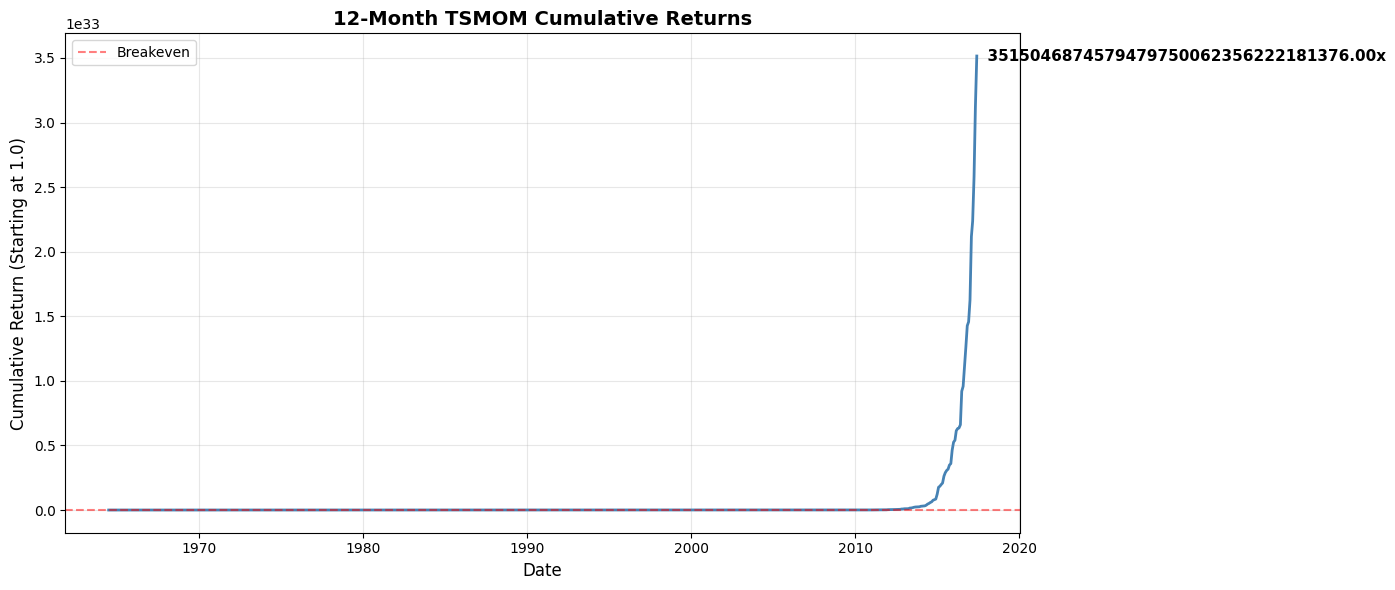

Start: 1963-08-01 00:00:00
End: 2017-06-01 00:00:00
Final value: 3515046874579479750062356222181376.00x
Total return: 351504687457947977312078631431831552.0%


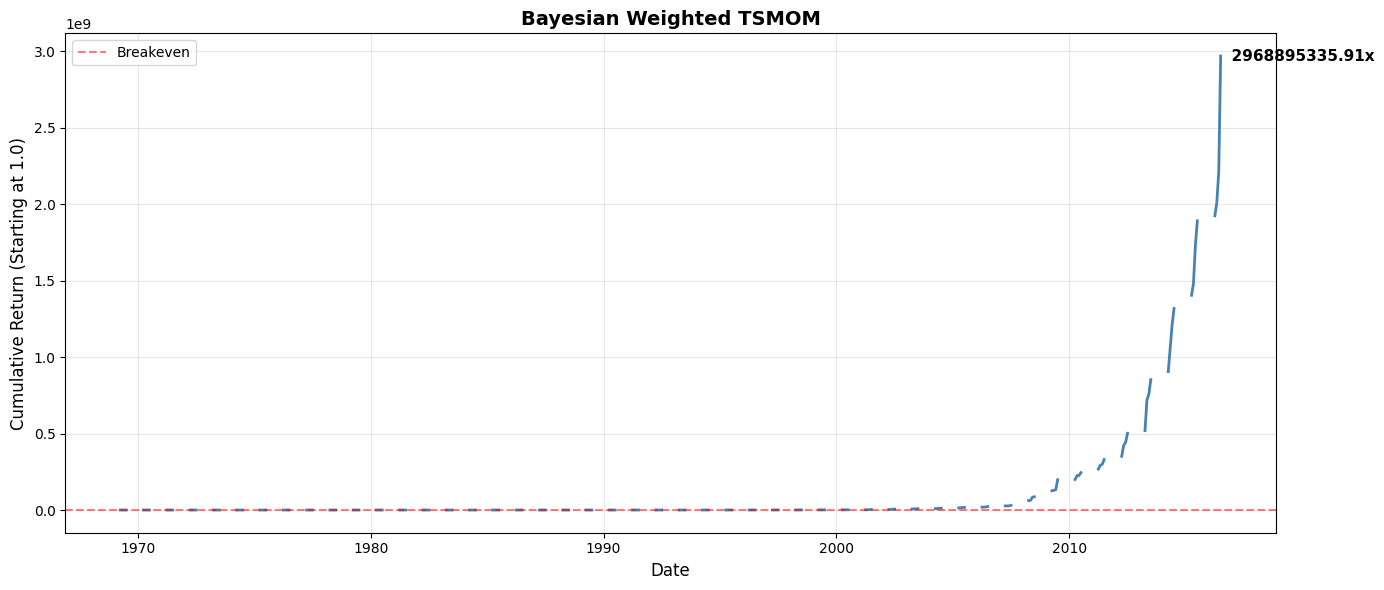

Start: 1968-08-01 00:00:00
End: 2016-07-01 00:00:00
Final value: 2968895335.91x
Total return: 296889533490.5%


In [7]:
def plot_cumulative_returns_simple(returns_series, title="Cumulative Returns"):
    """
    Plot cumulative returns for a single strategy.
    
    Parameters:
    returns_series: pd.Series of monthly returns
    title: str, plot title
    """
    import matplotlib.pyplot as plt
    
    # Calculate cumulative returns
    cum_returns = (returns_series+1).cumprod()
    
    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(cum_returns.index, cum_returns.values, linewidth=2, color='steelblue')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Return (Starting at 1.0)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=1, color='red', linestyle='--', alpha=0.5, label='Breakeven')
    plt.legend()
    
    # Add final value annotation
    final_val = cum_returns.iloc[-1]
    plt.text(cum_returns.index[-1], final_val, 
             f'  {final_val:.2f}x', 
             verticalalignment='center',
             fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print stats
    print(f"Start: {cum_returns.index[0]}")
    print(f"End: {cum_returns.index[-1]}")
    print(f"Final value: {final_val:.2f}x")
    print(f"Total return: {(final_val - 1) * 100:.1f}%")


# Usage:
# Test with 12-month strategy
tsmom_12m = tsmom_returns(monthly_returns, lookback=12)
portfolio_12m = tsmom_12m.mean(axis=1)
plot_cumulative_returns_simple(portfolio_12m, "12-Month TSMOM Cumulative Returns")

# Or with bayesian
plot_cumulative_returns_simple(bayesian_returns, "Bayesian Weighted TSMOM")